In [270]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from typing import Any
from tqdm import tqdm

In [271]:
DATA_PATH = "./data/aligned_data/"

In [272]:
with open("./data/aligned_ticker_1878.json") as jsf:
    new_tickers = json.load(jsf)

In [273]:
prices = pd.read_csv(f"{DATA_PATH}/prices.csv", parse_dates=True, index_col=0)
returns = pd.read_csv(f"{DATA_PATH}/returns.csv", parse_dates=True, index_col=0)
volume = pd.read_csv(f"{DATA_PATH}/volume.csv", parse_dates=True, index_col=0)
ychopmdf = pd.read_csv(f"{DATA_PATH}/ychopmdf.csv", parse_dates=True, index_col=0) / 100
asset_turnover = pd.read_csv(f"{DATA_PATH}/asset_turnover.csv", parse_dates=True, index_col=0)

company_info = pd.read_csv("./data/yf/company_info.csv")

In [274]:
returns

,A,AACAY,AAON,AAP,AAPL,AAT,AAV.TO,AAVVF,ABB,ABC,...,SCS,SCSC,SCU,SCVL,SCX,SDVKY,SEB,SEE,SEIC,SEKEY
Date,,,,,,,,,,,,,,,,,,,,,
2011-04-01,0.586536,NaN,0.355194,0.157275,0.288566,NaN,0.208848,0.311072,0.432402,0.276675,...,0.410389,0.407736,0.157262,0.385273,0.098881,0.378927,0.475129,0.210389,0.109220,0.301198
2012-04-01,-0.262032,0.236969,-0.135850,0.157420,0.553773,0.118403,-0.934785,-0.982091,-0.439737,-0.038167,...,-0.199491,-0.201501,-0.567271,0.066868,0.154782,-0.287481,-0.125421,-0.405714,-0.109512,-0.552735
2013-04-01,0.096460,0.672239,0.579970,0.177140,-0.372497,0.272265,-0.172378,-0.171769,0.321318,0.366548,...,0.507091,0.043430,0.436124,0.166484,0.200970,-0.033939,0.243728,0.470759,0.386543,0.316270
2014-04-01,0.302534,0.160821,0.425140,0.510634,0.519973,0.140325,0.546797,0.533907,0.093181,0.277842,...,0.063954,0.173953,0.414057,-0.140848,NaN,0.169797,0.109136,0.373093,0.155366,1.129708
2015-04-01,-0.051032,-0.115751,0.015867,0.167745,0.318698,0.150757,0.096957,-0.061369,-0.064598,0.393655,...,0.248629,-0.000525,-0.035830,0.346041,-0.000017,-0.169387,0.175310,0.421502,0.415696,-0.182981
2016-04-01,0.147733,0.427250,0.209181,0.016079,-0.253208,0.104247,-0.090008,-0.122740,-0.015394,-0.280468,...,-0.297708,-0.025277,-1.131736,-0.128979,-0.196490,-0.069521,-0.226121,-0.100356,-0.009254,-0.104858
2017-04-01,0.303812,0.417726,0.300240,-0.325103,0.430699,-0.049967,-0.349925,-0.342614,0.267806,0.192442,...,0.063109,0.082465,-0.391699,-0.174509,0.127574,0.484944,0.330909,-0.012960,0.122147,0.334316
2018-04-01,0.048267,0.126121,-0.095620,0.154032,0.266694,-0.000329,-0.757914,-0.778140,-0.100735,-0.085640,...,-0.000325,0.000000,-0.233301,0.453672,NaN,0.132774,-0.006645,-0.038588,0.160220,-0.254660
2019-04-01,0.197754,-0.901004,0.420750,0.128950,0.082025,0.234518,-0.924843,-0.924388,-0.048113,0.017778,...,0.272473,-0.213267,0.227359,-0.147682,0.033797,0.061740,0.044744,0.023460,-0.096093,-0.096123


To compose portfolios with lowest Operating Margin and highest Asset Turnover we need a way to select best candidates. To this end, I will constuct a matrix with the difference of normalized Asset Turnover and Operating Margin.

In [275]:
def min_max_scale(df: pd.DataFrame) -> pd.DataFrame:
    df = (df - df.min()) / (df.max() - df.min())
    return df.copy()

In [276]:
asset_turnover.T.describe()

date,2011-04-01,2012-04-01,2013-04-01,2014-04-01,2015-04-01,2016-04-01,2017-04-01,2018-04-01,2019-04-01,2020-04-01,2021-04-01,2022-04-01,2023-04-01
count,1305.000000,1370.000000,1439.000000,1429.000000,1435.000000,1432.000000,1418.000000,1426.000000,1435.000000,1428.000000,1431.000000,1406.000000,1422.000000
mean,1.010640,1.036952,1.019370,0.999019,0.982535,0.927663,0.906086,0.894694,0.899375,0.863448,0.775266,0.809848,0.886950
std,0.924548,0.937170,0.926441,0.922335,0.898722,0.812468,0.762356,0.750489,0.757387,0.719789,0.650543,0.694917,0.774880
min,0.012465,0.013403,-0.242140,0.011240,0.012108,0.009632,0.009705,0.011975,-0.055927,0.014530,0.006633,-1.900920,-0.785907
25%,0.458644,0.463316,0.457041,0.439247,0.444430,0.406542,0.408310,0.396130,0.396954,0.387464,0.350576,0.383198,0.415301
50%,0.795539,0.842319,0.809636,0.788305,0.763038,0.726132,0.725221,0.726637,0.727441,0.689295,0.624593,0.670920,0.725911
75%,1.275752,1.323878,1.312991,1.282075,1.250650,1.211298,1.198630,1.180717,1.197453,1.130541,1.002793,1.035381,1.122223
max,11.221488,11.055405,11.010551,11.414836,11.504301,11.203356,11.212121,10.510263,9.729531,9.352953,8.799283,8.883930,8.873837


<Axes: >

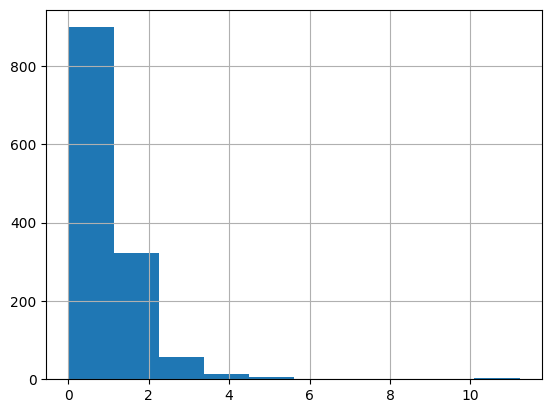

In [277]:
asset_turnover.T["2011-04-01"].hist()

In [278]:
asset_turnover.isna().sum().sort_values()

A        0
KMTUY    0
KMT      0
KMB      0
KLIC     0
        ..
PCTI     3
NLS      3
EHTH     3
AXON     3
LPX      3
Length: 1440, dtype: int64

In [279]:
diff_vector = (min_max_scale(asset_turnover.T) - min_max_scale(ychopmdf.T)).T

In [280]:
diff_vector.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13 entries, 2011-04-01 to 2023-04-01
Columns: 1440 entries, A to SEKEY
dtypes: float64(1440)
memory usage: 146.9 KB


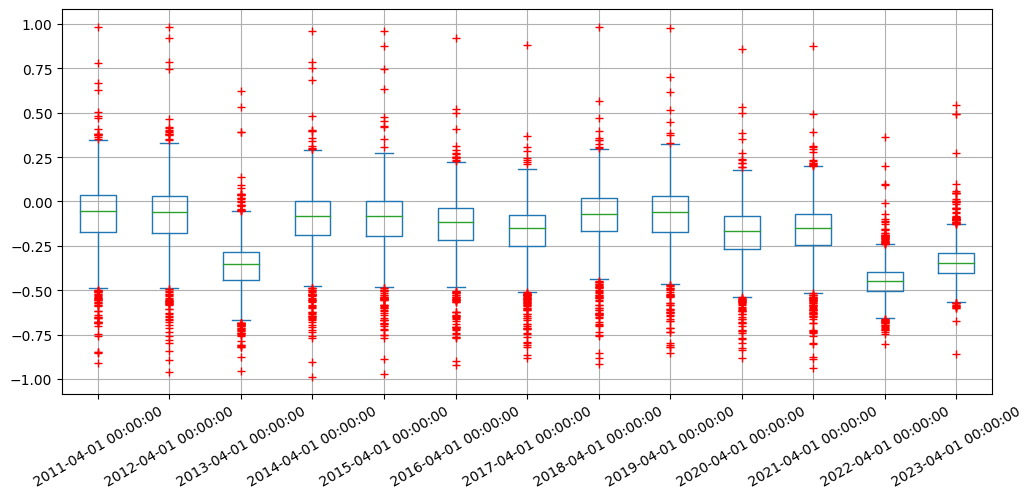

In [281]:
diff_vector.T.plot(kind="box", figsize=(12,5), rot=30, grid=True, sym="r+")
plt.show()

In [285]:
from dataclasses import dataclass, fields
from enum import Enum, auto


class PortfolioType(Enum):
    LOHT = auto()
    HOLT = auto()


@dataclass
class Universe:
    factors_df: pd.DataFrame
    operating_margin: pd.DataFrame
    asset_turnover: pd.DataFrame
    yoy_returns: pd.DataFrame
    volumes: pd.DataFrame
    sectors_info: pd.DataFrame

    def verify_candidates(self, candidates: list[str], year: pd.Timestamp) -> list[str]:
        candidates_with_nas = set()
        for field in fields(self):
            if field.name != "sectors_info":
                data_df_for_candidates = getattr(self, field.name).loc[:, candidates]
                count_nas = data_df_for_candidates.isna().sum()
                # print(field.name, count_nas.loc[count_nas > 0].index.to_list())
                candidates_with_nas.update(count_nas.loc[count_nas > 0].index.to_list())
            else:
                continue
        return sorted(candidates_with_nas)


# a = ychopmdf.loc[:, ['LIF.TO', 'NHI', 'PW', 'MSB', 'ANIK', 'CRT']]
# a.isna().sum().loc[a.isna().sum() > 0]


@dataclass
class Portfolio:
    create_date: pd.Timestamp
    hold: pd.DateOffset
    ptype: PortfolioType

    def __post_init__(self):
        self.symbols: list[str] | None = None
        self.info: pd.DataFrame | None = None

    def fit(self, candidates: list[str], universe: Universe):
        self.symbols = candidates
        self.info = pd.concat(
            [
                universe.factors_df.loc[self.create_date, candidates],  # type: ignore
                universe.yoy_returns.loc[self.create_date, candidates],  # type: ignore
                universe.yoy_returns.loc[self.create_date + self.hold, candidates],  # type: ignore
                universe.operating_margin.loc[self.create_date, candidates],  # type: ignore
                universe.operating_margin.loc[self.create_date + self.hold, candidates],  # type: ignore
                universe.asset_turnover.loc[self.create_date, candidates],  # type: ignore
                universe.asset_turnover.loc[self.create_date + self.hold, candidates],  # type: ignore
                universe.volumes.loc[self.create_date, candidates],  # type: ignore
                universe.volumes.loc[self.create_date + self.hold, candidates],  # type: ignore
            ],
            axis=1,
        )
        self.info.columns = [
            "diff_vector",
            "r_i",
            "r_ii",
            "opm_i",
            "opm_ii",
            "a_turnover_i",
            "a_turnover_ii",
            "volume_i",
            "volume_ii",
        ]

In [295]:
class Strategy:
    def __init__(self):
        self.portfolios: dict[str, tuple[Portfolio, Portfolio]] = dict()

    @classmethod
    def multi_delete(cls, list_: list[Any], args) -> list[Any]:
        list_ = [e for e in list_ if e not in args]
        return list_

    def construct_portfolios(
        self,
        universe: Universe,
        hold: pd.DateOffset,
        plength: int = 6,
    ):
        for year in tqdm(universe.factors_df.index[:-1]):
            lohts, holts = [], []
            ranking: list[str] = (
                universe.factors_df.loc[year].sort_values(ascending=False).dropna()
            ).index.to_list()
            while (found := False) != True and (counter := 100) > 0:
                lohts, holts = ranking[:plength], ranking[-plength:]
                lohts_misses = universe.verify_candidates(lohts, year + hold)
                holts_misses = universe.verify_candidates(holts, year + hold)
                # print(f"{lohts_misses=}")
                # print(f"{holts_misses=}")
                ranking = type(self).multi_delete(ranking, lohts_misses)
                ranking = type(self).multi_delete(ranking, holts_misses)
                # print(len(ranking), len(lohts_misses), len(holts_misses))
                if (len(lohts_misses) + len(holts_misses)) == 0:
                    found = True
                    break
                counter -= 1
            loht_portfolio = Portfolio(create_date=year, hold=hold, ptype=PortfolioType.LOHT)
            loht_portfolio.fit(candidates=lohts, universe=universe)
            holt_portfolio = Portfolio(create_date=year, hold=hold, ptype=PortfolioType.HOLT)
            holt_portfolio.fit(candidates=lohts, universe=universe)
            year_str = year.strftime("%Y-%m-%d")
            self.portfolios[year_str] = (loht_portfolio, holt_portfolio)  # type: ignore

In [296]:
universe = Universe(diff_vector, ychopmdf, asset_turnover, returns, volume, company_info)
strategy = Strategy()
strategy.construct_portfolios(universe, pd.DateOffset(years=1))

100%|██████████| 12/12 [00:00<00:00, 28.60it/s]


In [297]:
# strategy.portfolios['2011-04-01'][0].info

atest_df = pd.concat([port[0].info for port in strategy.portfolios.values()]) # type: ignore

In [ ]:
bool([1])

True

In [ ]:
ychopmdf.loc[:, "ANIK"]

date
2011-04-01    0.153500
2012-04-01    0.171575
2013-04-01    0.268500
2014-04-01    0.388425
2015-04-01    0.570950
2016-04-01    0.499800
2017-04-01    0.517600
2018-04-01    0.440600
2019-04-01    0.222925
2020-04-01    0.324825
2021-04-01    0.048400
2022-04-01   -1.640877
2023-04-01         NaN
Name: ANIK, dtype: float64

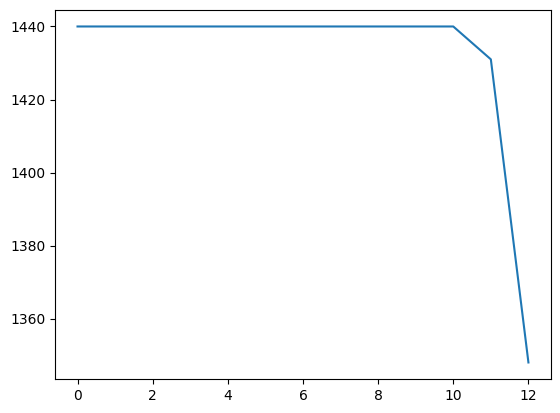

In [ ]:
plt.plot([prices.dropna(axis=1, thresh=i).shape[1] for i in range(13)])

In [ ]:
(prices.isna().sum())

A        0
AACAY    1
AAON     0
AAP      0
AAPL     0
        ..
SDVKY    0
SEB      0
SEE      0
SEIC     0
SEKEY    0
Length: 1440, dtype: int64

In [ ]:
prices.loc[:, "AE"]

Date
2011-04-01    19.116041
2012-04-01    32.295795
2013-04-01    54.110939
2014-04-01    62.233257
2015-04-01    36.056576
2016-04-01    31.798153
2017-04-01    34.728657
2018-04-01    34.471493
2019-04-01    30.235395
2020-04-01    24.346373
2021-04-01    25.929681
2022-04-01    31.382593
2023-04-01    33.299999
Name: AE, dtype: float64

In [ ]:
diff_vector.index[:-1]

DatetimeIndex(['2011-04-01', '2012-04-01', '2013-04-01', '2014-04-01',
               '2015-04-01', '2016-04-01', '2017-04-01', '2018-04-01',
               '2019-04-01', '2020-04-01', '2021-04-01', '2022-04-01'],
              dtype='datetime64[ns]', name='date', freq=None)

In [ ]:
year = diff_vector.index[0]
test = diff_vector.loc[year].sort_values(ascending=False).dropna()
symbols = test[-6:].index
symbols

Index(['LIF.TO', 'NHI', 'PW', 'MSB', 'HKXCY', 'CRT'], dtype='object')

In [ ]:
a = ['LIF.TO', 'NHI', 'PW', 'MSB', 'CRT']
Strategy.multi_delete(a, ['LIF.TO', 'NHI'])

['PW', 'MSB', 'CRT']

In [ ]:
a = ychopmdf.loc[:, ['LIF.TO', 'NHI', 'PW', 'MSB', 'CRT']]
pd.Index(a.isna().sum().loc[a.isna().sum() > 0].index)

Index([], dtype='object')

In [ ]:
test_df = pd.DataFrame(test[-6:])
test_df.columns = ["diff"]
test_df

,diff
LIF.TO,-0.744480
NHI,-0.758038
PW,-0.846656
MSB,-0.849395
HKXCY,-0.854122
CRT,-0.908996


In [ ]:
holts_names = test[-6:].index

In [ ]:
diff_vector.loc[year, holts_names] # type: ignore

LIF.TO   -0.744480
NHI      -0.758038
PW       -0.846656
MSB      -0.849395
HKXCY    -0.854122
CRT      -0.908996
Name: 2011-04-01 00:00:00, dtype: float64

In [ ]:
test_df.loc[:, "operating_margin"] = ychopmdf.loc[year, holts_names]

In [ ]:
pd.concat(
    [
        test_df,
        ychopmdf.loc[year, holts_names],
        asset_turnover.loc[year, holts_names],
        returns.loc[year, holts_names],
    ],
    axis=1,
)

,diff,operating_margin,2011-04-01 00:00:00,2011-04-01 00:00:00,2011-04-01 00:00:00
LIF.TO,-0.744480,0.748900,0.748900,0.274136,0.679319
NHI,-0.758038,0.753100,0.753100,0.170497,0.196301
PW,-0.846656,0.833250,0.833250,0.099516,0.201585
MSB,-0.849395,0.966333,0.966333,1.600290,0.734205
HKXCY,-0.854122,0.845100,0.845100,0.152197,0.326032
CRT,-0.908996,0.975050,0.975050,1.032530,0.325224


In [ ]:
test_df.join(pd.Series(ychopmdf.loc[year, holts_names], name="operating_margin"))

ValueError: columns overlap but no suffix specified: Index(['operating_margin'], dtype='object')